In [1]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy        
import statsmodels


from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 999

sns.set()

plt.rcParams["figure.figsize"] = (10,7)

In [36]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, plot_confusion_matrix, classification_report
import shap

In [2]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
from sigmod_src.utils import read_json, pprint_json, path_from_spec_id, get_vector_for_spec_id
from sigmod_src.data.embedding import Embedder

# Load data

In [7]:
labelled_dataset_path = '../data/processed/labelled_features.csv'

In [8]:
df = pd.read_csv(labelled_dataset_path)

In [9]:
df.shape

(46665, 2005)

In [10]:
df.head()

,left_spec_id,right_spec_id,label,left_page_title_stem__0mp,left_page_title_stem__10,left_page_title_stem__10 1mp,left_page_title_stem__10 cctv,left_page_title_stem__10 megapixel,left_page_title_stem__10 mp,left_page_title_stem__100,left_page_title_stem__1000d,left_page_title_stem__100d,left_page_title_stem__1080p,left_page_title_stem__1080p dome,left_page_title_stem__1080p full,left_page_title_stem__1080p hd,left_page_title_stem__1080p ip,left_page_title_stem__10mp,left_page_title_stem__10mp sale,left_page_title_stem__10x,left_page_title_stem__10x optic,left_page_title_stem__1100d,left_page_title_stem__1100d 12,left_page_title_stem__115,left_page_title_stem__12,left_page_title_stem__12 1mp,left_page_title_stem__12 megapixel,left_page_title_stem__12 mp,left_page_title_stem__1200d,left_page_title_stem__12mp,left_page_title_stem__12x,left_page_title_stem__135,left_page_title_stem__14,left_page_title_stem__14 2mp,left_page_title_stem__14 megapixel,left_page_title_stem__14 mp,left_page_title_stem__14mp,left_page_title_stem__15,left_page_title_stem__15 mp,left_page_title_stem__150,left_page_title_stem__16,left_page_title_stem__16 1mp,left_page_title_stem__16 2mp,left_page_title_stem__16 megapixel,left_page_title_stem__16 mp,left_page_title_stem__16gb,left_page_title_stem__16mp,left_page_title_stem__16mp sale,left_page_title_stem__16x,left_page_title_stem__18,left_page_title_stem__18 55,left_page_title_stem__18 55mm,left_page_title_stem__18 mp,left_page_title_stem__18mp,left_page_title_stem__18x,left_page_title_stem__1d,left_page_title_stem__1d mark,left_page_title_stem__1mp,left_page_title_stem__1mp bodi,left_page_title_stem__20,left_page_title_stem__20 1mp,left_page_title_stem__20 mp,left_page_title_stem__200,left_page_title_stem__200mm,left_page_title_stem__2013,left_page_title_stem__2014,left_page_title_stem__2014 hot,left_page_title_stem__20d,left_page_title_stem__20mp,left_page_title_stem__20x,left_page_title_stem__20x optic,left_page_title_stem__21,left_page_title_stem__21 mp,left_page_title_stem__21x,left_page_title_stem__22,left_page_title_stem__22 mp,left_page_title_stem__24,left_page_title_stem__24 mp,left_page_title_stem__26x,left_page_title_stem__28,left_page_title_stem__2mp,left_page_title_stem__2mp bodi,left_page_title_stem__2mp dahua,left_page_title_stem__2mp ir,left_page_title_stem__30,left_page_title_stem__300,left_page_title_stem__30d,left_page_title_stem__30m,left_page_title_stem__30x,left_page_title_stem__32,left_page_title_stem__32gb,left_page_title_stem__350d,left_page_title_stem__35mm,left_page_title_stem__36,left_page_title_stem__36 mp,left_page_title_stem__360,left_page_title_stem__3d,left_page_title_stem__3g,left_page_title_stem__3mp,left_page_title_stem__3mp bullet,left_page_title_stem__3mp dome,left_page_title_stem__3mp full,left_page_title_stem__3mp ir,left_page_title_stem__3x,left_page_title_stem__3x optic,left_page_title_stem__3x zoom,left_page_title_stem__40,left_page_title_stem__400d,left_page_title_stem__400d 10,left_page_title_stem__40d,left_page_title_stem__40d 10,left_page_title_stem__450d,left_page_title_stem__4x,left_page_title_stem__50,left_page_title_stem__500,left_page_title_stem__500d,left_page_title_stem__500d 15,left_page_title_stem__50d,left_page_title_stem__50mm,left_page_title_stem__50x,left_page_title_stem__55,left_page_title_stem__550d,left_page_title_stem__550d 18,left_page_title_stem__55mm,left_page_title_stem__55mm len,left_page_title_stem__5d,left_page_title_stem__5d mark,left_page_title_stem__5mp,left_page_title_stem__5mp ir,left_page_title_stem__5n,left_page_title_stem__5x,left_page_title_stem__5x optic,left_page_title_stem__5x zoom,left_page_title_stem__60,left_page_title_stem__600d,left_page_title_stem__600d 18,left_page_title_stem__60d,left_page_title_stem__60d 18,left_page_title_stem__6d,left_page_title_stem__6mp,left_page_title_stem__70,left_page_title_stem__700d,left_page_title_stem__700tvl,left_page_title_stem__70d,left_page_title_stem__70d 20,left_page_title_stem__720p

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46665 entries, 0 to 46664
Columns: 2005 entries, left_spec_id to right_site_enc
dtypes: float64(2000), int64(3), object(2)
memory usage: 713.8+ MB


# Load embedder and index

In [12]:
emb = Embedder.load('../models/embedder')

/home/boris/anaconda3/lib/python3.6/site-packages/gensim/similarities/index.py:159: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  self.index = AnnoyIndex(d['f'])


# Load specs df

In [15]:
specs_df = pd.read_csv('../data/processed/specs_features.csv')
specs_df.index=  specs_df.spec_id
specs_df.shape

(29771, 1006)

In [16]:
specs_df[specs_df.page_title.isnull()]

,spec_id,page_title,page_title_stem,brand,site,page_title_stem__0mp,page_title_stem__10,page_title_stem__10 1mp,page_title_stem__10 cctv,page_title_stem__10 megapixel,page_title_stem__10 mp,page_title_stem__100,page_title_stem__1000d,page_title_stem__100d,page_title_stem__1080p,page_title_stem__1080p dome,page_title_stem__1080p full,page_title_stem__1080p hd,page_title_stem__1080p ip,page_title_stem__10mp,page_title_stem__10mp sale,page_title_stem__10x,page_title_stem__10x optic,page_title_stem__1100d,page_title_stem__1100d 12,page_title_stem__115,page_title_stem__12,page_title_stem__12 1mp,page_title_stem__12 megapixel,page_title_stem__12 mp,page_title_stem__1200d,page_title_stem__12mp,page_title_stem__12x,page_title_stem__135,page_title_stem__14,page_title_stem__14 2mp,page_title_stem__14 megapixel,page_title_stem__14 mp,page_title_stem__14mp,page_title_stem__15,page_title_stem__15 mp,page_title_stem__150,page_title_stem__16,page_title_stem__16 1mp,page_title_stem__16 2mp,page_title_stem__16 megapixel,page_title_stem__16 mp,page_title_stem__16gb,page_title_stem__16mp,page_title_stem__16mp sale,page_title_stem__16x,page_title_stem__18,page_title_stem__18 55,page_title_stem__18 55mm,page_title_stem__18 mp,page_title_stem__18mp,page_title_stem__18x,page_title_stem__1d,page_title_stem__1d mark,page_title_stem__1mp,page_title_stem__1mp bodi,page_title_stem__20,page_title_stem__20 1mp,page_title_stem__20 mp,page_title_stem__200,page_title_stem__200mm,page_title_stem__2013,page_title_stem__2014,page_title_stem__2014 hot,page_title_stem__20d,page_title_stem__20mp,page_title_stem__20x,page_title_stem__20x optic,page_title_stem__21,page_title_stem__21 mp,page_title_stem__21x,page_title_stem__22,page_title_stem__22 mp,page_title_stem__24,page_title_stem__24 mp,page_title_stem__26x,page_title_stem__28,page_title_stem__2mp,page_title_stem__2mp bodi,page_title_stem__2mp dahua,page_title_stem__2mp ir,page_title_stem__30,page_title_stem__300,page_title_stem__30d,page_title_stem__30m,page_title_stem__30x,page_title_stem__32,page_title_stem__32gb,page_title_stem__350d,page_title_stem__35mm,page_title_stem__36,page_title_stem__36 mp,page_title_stem__360,page_title_stem__3d,page_title_stem__3g,page_title_stem__3mp,page_title_stem__3mp bullet,page_title_stem__3mp dome,page_title_stem__3mp full,page_title_stem__3mp ir,page_title_stem__3x,page_title_stem__3x optic,page_title_stem__3x zoom,page_title_stem__40,page_title_stem__400d,page_title_stem__400d 10,page_title_stem__40d,page_title_stem__40d 10,page_title_stem__450d,page_title_stem__4x,page_title_stem__50,page_title_stem__500,page_title_stem__500d,page_title_stem__500d 15,page_title_stem__50d,page_title_stem__50mm,page_title_stem__50x,page_title_stem__55,page_title_stem__550d,page_title_stem__550d 18,page_title_stem__55mm,page_title_stem__55mm len,page_title_stem__5d,page_title_stem__5d mark,page_title_stem__5mp,page_title_stem__5mp ir,page_title_stem__5n,page_title_stem__5x,page_title_stem__5x optic,page_title_stem__5x zoom,page_title_stem__60,page_title_stem__600d,page_title_stem__600d 18,page_title_stem__60d,page_title_stem__60d 18,page_title_stem__6d,page_title_stem__6mp,page_title_stem__70,page_title_stem__700d,page_title_stem__700tvl,page_title_stem__70d,page_title_stem__70d 20,page_title_stem__720p,page_title_stem__720p hd,page_title_stem__75,page_title_stem__7d,page_title_stem__7d 18,page_title_stem__8gb,page_title_stem__8mp,page_title_stem__8x,page_title_stem__960p,page_title_stem__a3000,page_title_stem__a6000,page_title_stem__a7,page_title_stem__accessori,page_title_stem__action,page_title_stem__af,page_title_stem__ahd,page_title_stem__alarm,page_title_stem__alibaba,page_title_stem__alpha,page_title_stem__alpha a6000,page_title_stem__alpha nex,page_title_stem__alpha slt,page_title_stem__aluminum,page_title_stem__analog,page_title_stem__angl,page_title_stem__array,page_title_stem__arriv,page_title_stem__audio,page_title_stem__auto,page_title_stem__aw120,page_title_stem__backpack,page_

In [17]:
specs_df.head()

,spec_id,page_title,page_title_stem,brand,site,page_title_stem__0mp,page_title_stem__10,page_title_stem__10 1mp,page_title_stem__10 cctv,page_title_stem__10 megapixel,page_title_stem__10 mp,page_title_stem__100,page_title_stem__1000d,page_title_stem__100d,page_title_stem__1080p,page_title_stem__1080p dome,page_title_stem__1080p full,page_title_stem__1080p hd,page_title_stem__1080p ip,page_title_stem__10mp,page_title_stem__10mp sale,page_title_stem__10x,page_title_stem__10x optic,page_title_stem__1100d,page_title_stem__1100d 12,page_title_stem__115,page_title_stem__12,page_title_stem__12 1mp,page_title_stem__12 megapixel,page_title_stem__12 mp,page_title_stem__1200d,page_title_stem__12mp,page_title_stem__12x,page_title_stem__135,page_title_stem__14,page_title_stem__14 2mp,page_title_stem__14 megapixel,page_title_stem__14 mp,page_title_stem__14mp,page_title_stem__15,page_title_stem__15 mp,page_title_stem__150,page_title_stem__16,page_title_stem__16 1mp,page_title_stem__16 2mp,page_title_stem__16 megapixel,page_title_stem__16 mp,page_title_stem__16gb,page_title_stem__16mp,page_title_stem__16mp sale,page_title_stem__16x,page_title_stem__18,page_title_stem__18 55,page_title_stem__18 55mm,page_title_stem__18 mp,page_title_stem__18mp,page_title_stem__18x,page_title_stem__1d,page_title_stem__1d mark,page_title_stem__1mp,page_title_stem__1mp bodi,page_title_stem__20,page_title_stem__20 1mp,page_title_stem__20 mp,page_title_stem__200,page_title_stem__200mm,page_title_stem__2013,page_title_stem__2014,page_title_stem__2014 hot,page_title_stem__20d,page_title_stem__20mp,page_title_stem__20x,page_title_stem__20x optic,page_title_stem__21,page_title_stem__21 mp,page_title_stem__21x,page_title_stem__22,page_title_stem__22 mp,page_title_stem__24,page_title_stem__24 mp,page_title_stem__26x,page_title_stem__28,page_title_stem__2mp,page_title_stem__2mp bodi,page_title_stem__2mp dahua,page_title_stem__2mp ir,page_title_stem__30,page_title_stem__300,page_title_stem__30d,page_title_stem__30m,page_title_stem__30x,page_title_stem__32,page_title_stem__32gb,page_title_stem__350d,page_title_stem__35mm,page_title_stem__36,page_title_stem__36 mp,page_title_stem__360,page_title_stem__3d,page_title_stem__3g,page_title_stem__3mp,page_title_stem__3mp bullet,page_title_stem__3mp dome,page_title_stem__3mp full,page_title_stem__3mp ir,page_title_stem__3x,page_title_stem__3x optic,page_title_stem__3x zoom,page_title_stem__40,page_title_stem__400d,page_title_stem__400d 10,page_title_stem__40d,page_title_stem__40d 10,page_title_stem__450d,page_title_stem__4x,page_title_stem__50,page_title_stem__500,page_title_stem__500d,page_title_stem__500d 15,page_title_stem__50d,page_title_stem__50mm,page_title_stem__50x,page_title_stem__55,page_title_stem__550d,page_title_stem__550d 18,page_title_stem__55mm,page_title_stem__55mm len,page_title_stem__5d,page_title_stem__5d mark,page_title_stem__5mp,page_title_stem__5mp ir,page_title_stem__5n,page_title_stem__5x,page_title_stem__5x optic,page_title_stem__5x zoom,page_title_stem__60,page_title_stem__600d,page_title_stem__600d 18,page_title_stem__60d,page_title_stem__60d 18,page_title_stem__6d,page_title_stem__6mp,page_title_stem__70,page_title_stem__700d,page_title_stem__700tvl,page_title_stem__70d,page_title_stem__70d 20,page_title_stem__720p,page_title_stem__720p hd,page_title_stem__75,page_title_stem__7d,page_title_stem__7d 18,page_title_stem__8gb,page_title_stem__8mp,page_title_stem__8x,page_title_stem__960p,page_title_stem__a3000,page_title_stem__a6000,page_title_stem__a7,page_title_stem__accessori,page_title_stem__action,page_title_stem__af,page_title_stem__ahd,page_title_stem__alarm,page_title_stem__alibaba,page_title_stem__alpha,page_title_stem__alpha a6000,page_title_stem__alpha nex,page_title_stem__alpha slt,page_title_stem__aluminum,page_title_stem__analog,page_title_stem__angl,page_title_stem__array,page_title_stem__arriv,page_title_stem__audio,page_title_stem__auto,page_title_stem__aw120,page_title_stem__backpack,page_

In [18]:
spec_feature_names = set(specs_df.columns).difference(['page_title', 'page_title_stem', 'brand', 'site'])
len(spec_feature_names)

1002

# Evaluate classifier

## Obtain train/test split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = df.drop(['label', 'left_spec_id', 'right_spec_id'], axis=1)
Y = df.label

In [21]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, stratify=Y)
train_Y.shape, test_Y.shape

((34998,), (11667,))

In [22]:
train_X.shape, test_X.shape

((34998, 2002), (11667, 2002))

## LGB

In [23]:
from lightgbm import LGBMClassifier

In [24]:
from sklearn.metrics import f1_score, plot_confusion_matrix, classification_report

In [25]:
train_Y.value_counts()

0    32312
1     2686
Name: label, dtype: int64

In [26]:
test_Y.value_counts()

0    10771
1      896
Name: label, dtype: int64

In [28]:
sample_pos_weight = Y.value_counts()[0] / Y.value_counts()[1]
sample_pos_weight

12.027638190954773

In [29]:
clf = LGBMClassifier(sample_pos_weight=sample_pos_weight)

In [30]:
clf.fit(train_X, train_Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0,
               sample_pos_weight=12.027638190954773, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=1)

In [37]:
pred_train_Y = clf.predict(train_X)

In [38]:
print('Train F1', f1_score(train_Y, pred_train_Y))
print(classification_report(train_Y, pred_train_Y))

Train F1 0.9992548435171386
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32312
           1       1.00      1.00      1.00      2686

    accuracy                           1.00     34998
   macro avg       1.00      1.00      1.00     34998
weighted avg       1.00      1.00      1.00     34998



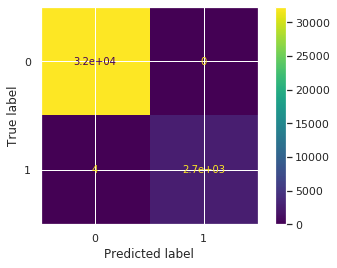

In [39]:
plot_confusion_matrix(clf, train_X, train_Y)

In [40]:
pred_test_Y = clf.predict(test_X)

In [41]:
print('Test F1', f1_score(test_Y, pred_test_Y))
print(classification_report(test_Y, pred_test_Y))

Test F1 0.9864559819413092
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10771
           1       1.00      0.98      0.99       896

    accuracy                           1.00     11667
   macro avg       1.00      0.99      0.99     11667
weighted avg       1.00      1.00      1.00     11667



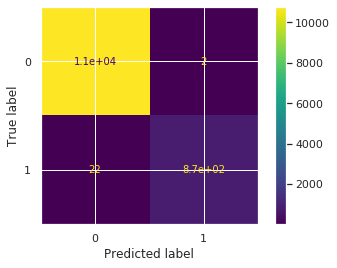

In [42]:
plot_confusion_matrix(clf, test_X, test_Y)

# Feature importance

In [43]:
explainer = shap.TreeExplainer(clf)

In [44]:
shap_values = explainer.shap_values(train_X)

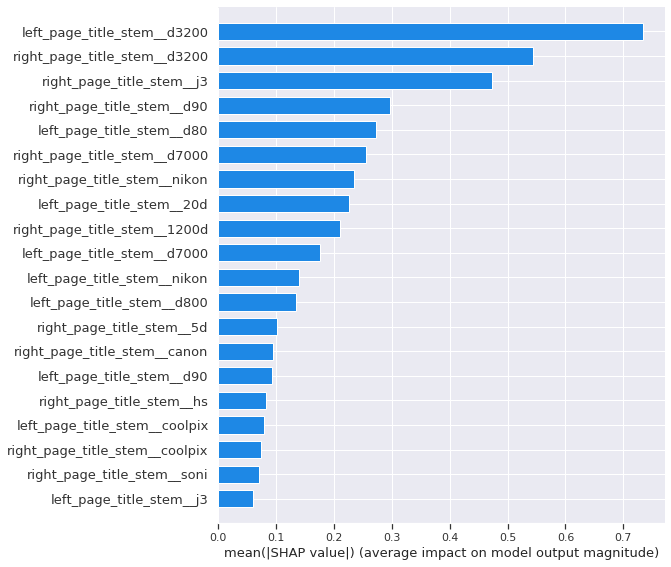

In [45]:
shap.summary_plot(shap_values, train_X, plot_type="bar")

# Submit

## Train on whole train data

In [38]:
del train_X
del test_X
del train_Y
del test_Y

In [39]:
clf.fit(X, Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0,
               sample_pos_weight=12.027638190954773, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=1)

## Generate submit

In [40]:
clf_column_order = df.drop(['label'], axis=1).columns
clf_column_order

Index(['left_spec_id', 'right_spec_id', 'left_page_title_stem__00',
       'left_page_title_stem__013803117493', 'left_page_title_stem__0mp',
       'left_page_title_stem__10', 'left_page_title_stem__10 30mm',
       'left_page_title_stem__10 cctv', 'left_page_title_stem__10 mp',
       'left_page_title_stem__100',
       ...
       'right_page_title_stem__work', 'right_page_title_stem__zealand',
       'right_page_title_stem__zealand price', 'right_page_title_stem__zoom',
       'right_page_title_stem__zoom black', 'right_page_title_stem__zoom buy',
       'right_page_title_stem__zoom digit', 'right_page_title_stem__zoom len',
       'right_page_title_stem__zoom mp', 'right_site_enc'],
      dtype='object', length=2004)

In [41]:
OUT_FILE_PATH = '../data/submit/submit.csv'

if os.path.exists(OUT_FILE_PATH):
    os.remove(OUT_FILE_PATH)

In [42]:
buffer_size = 10000

In [43]:
def get_candidate_specs(query_text, emb, indexer):
    nns = emb_lookup(query_text, emb, indexer, n=30)
    nn_spec_ids = [nn[0] for nn in nns]
    return nn_spec_ids

def predict_duplicates(clf, chunk_df):
    X = chunk_df.drop(['left_spec_id', 'right_spec_id'], axis=1)
    predicted_label = clf.predict(X)
    return predicted_label

def write_chunk_df(chunk_df):
    out_df = chunk_df[chunk_df.label == 1][['left_spec_id', 'right_spec_id']]
    if not out_df.empty:
        if os.path.exists(OUT_FILE_PATH):
            out_df.to_csv(OUT_FILE_PATH, mode='a', header=False, index=False)
        else:
            out_df.to_csv(OUT_FILE_PATH, index=False)

        print('Wrote ', out_df.shape[0], ' dupliates to disk')

def process_buffered_rows(row_buffer):
    row_columns = ['left_'+col for col in spec_feature_names]+['right_'+col for col in spec_feature_names]
    chunk_df = pd.DataFrame(row_buffer, columns=row_columns)
    chunk_df = chunk_df[clf_column_order]
    chunk_df['label'] = predict_duplicates(clf, chunk_df) 
    write_chunk_df(chunk_df)

In [44]:
row_buffer = []
for left_index, spec_row in tqdm(specs_df.iterrows()):
    left_spec_id = spec_row.spec_id
    candidates = get_candidate_specs(spec_row.page_title_stem, emb, indexer)
    for right_spec_id in candidates:
        if left_spec_id == right_spec_id:
            continue
        
        left_brand = specs_df.loc[left_spec_id].brand
        right_brand = specs_df.loc[right_spec_id].brand
        
        # Different brands, so we can just skip it
        if ((left_brand is not None) and (right_brand is not None) and (left_brand != right_brand)):
            continue
    
        left_row = specs_df.loc[left_spec_id][spec_feature_names]
        right_row = specs_df.loc[right_spec_id][spec_feature_names]
        features_row = np.concatenate([left_row.values, right_row.values])
        row_buffer.append(features_row)
    
    if len(row_buffer) >= buffer_size:
        process_buffered_rows(row_buffer)  
        row_buffer = []

if row_buffer:
    process_buffered_rows(row_buffer)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Wrote  1990  dupliates to disk
Wrote  1910  dupliates to disk
Wrote  1968  dupliates to disk
Wrote  1828  dupliates to disk
Wrote  2214  dupliates to disk
Wrote  1830  dupliates to disk
Wrote  1771  dupliates to disk
Wrote  2093  dupliates to disk
Wrote  2003  dupliates to disk
Wrote  1976  dupliates to disk
Wrote  1790  dupliates to disk
Wrote  1846  dupliates to disk
Wrote  1831  dupliates to disk
Wrote  1290  dupliates to disk
Wrote  2901  dupliates to disk
Wrote  2242  dupliates to disk
Wrote  2625  dupliates to disk
Wrote  2055  dupliates to disk
Wrote  1266  dupliates to disk
Wrote  2038  dupliates to disk
Wrote  2154  dupliates to disk
Wrote  1474  dupliates to disk
Wrote  22  dupliates to disk
Wrote  56  dupliates to disk
Wrote  40  dupliates to disk
Wrote  53  dupliates to disk
Wrote  40  dupliates to disk
Wrote  508  dupliates to disk
Wrote  1118  dupliates to disk

Wrote  870  dupliates to disk


In [48]:
submit_df = pd.read_csv('../data/submit/submit.csv')

In [49]:
submit_df.head()

,left_spec_id,right_spec_id
0,www.ebay.com//57656,www.ebay.com//45751
1,www.ebay.com//57656,www.ebay.com//53740
2,www.ebay.com//57656,www.ebay.com//47344
3,www.ebay.com//57656,www.ebay.com//59630
4,www.ebay.com//57656,www.ebay.com//58925


In [51]:
submit_df.shape

(45802, 2)